In [9]:
import pandas as pd
import csv

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def parse_annotations(labels_df):
    """"
    :ivar: DF of Davici Annotations
    :return: DF with labels[label, from(sec), to(sec), duration(sec)
    """
    annotations = pd.DataFrame()
    for i, row in labels_df.iterrows():
        if row['Notes'] != 'End' and row['Notes'] != 'end':
            raw_label = row['Notes'].split(',')
            if len(raw_label) == 1:
                sem_class = raw_label[0]
                hand = 'b'
            else:
                sem_class = raw_label[0]
                hand = raw_label[1]

            annotation_holder = {
                'label': sem_class,
                'hand' : hand,
                'from': get_sec(row['Record In'][3:]),
                'to': get_sec(labels_df.iloc[i + 1]['Record In'][3:] )}
            annotation_holder['duration'] = annotation_holder['to'] - annotation_holder['from']

            annotations = annotations.append(annotation_holder, ignore_index=True)
    return annotations

def get_sec(time_str):
    m, s, mm = time_str.split(':')
    return int(m) * 60 + int(s) + float(mm)/100

**Read data**

In [10]:
labels_file = pd.read_csv("/content/Stefanie.csv")
labels_full = parse_annotations(labels_file)


In [11]:
import pandas as pd

file_L = "/content/stefanie_L.csv"
file_R = "/content/stefanie_R.csv"

data_L = pd.read_csv(file_L)
data_R = pd.read_csv(file_R)

# **Exporting labels**

In [12]:
labels_to_idx = {
            'screwing':0,
            'cordless': 1,
            'fuegen': 2,
            'sawing': 3,
            'handling': 4,
            'handeling': 4, #typo in annotations
            'hammering': 5,
            'sorting': 6,
            'measuring ': 7,#typo
            'measuring' : 7,
            'cabeling' :8, #typo
            'cabling': 8,
            'background': 9,
            '0': -10 # data with this label will be cut off / left out (incorrect synchronisation...)
        }

In [13]:
import numpy as np

def annotate_IMU_data(dataframe, labels, class_as_string=True):
    data = dataframe.copy()
    data['timestamp_mills_ms'] -= data['timestamp_mills_ms'][0]
    data['timestamp_mills_ms'] /= 1000

    data['label'] = 0
    data['hand'] = 0

    for num_row, row in enumerate(labels.iterrows()):
        label = row[1]['label']
        hand = row[1]['hand']

        data['label'] = np.where(((data['timestamp_mills_ms'] >= row[1]['from']) & (data['timestamp_mills_ms'] < row[1]['to'])), label, data['label'])
        data['hand'] = np.where(((data['timestamp_mills_ms'] >= row[1]['from']) & (data['timestamp_mills_ms'] < row[1]['to'])), hand, data['hand'])

    if not class_as_string:
        for index, row in data.iterrows():
            data.loc[index, 'label'] = labels_to_idx[data.loc[index, 'label']]

    cut_data = data[data['label'] != '0']

    return cut_data

def annotate_n_cut_IMUs(data_L, data_R, labels):
    data_L = annotate_IMU_data(data_L, labels)
    data_R = annotate_IMU_data(data_R, labels)

    last_timestamp_L = data_L['timestamp_mills_ms'].iloc[-1]
    last_timestamp_R = data_R['timestamp_mills_ms'].iloc[-1]

    #potentially, IMUs streams are not cut off properly
    if abs(last_timestamp_L - last_timestamp_R) > 1: #difference > 1 sec
        if last_timestamp_L > last_timestamp_R:
            data_L = data_L[data_L['timestamp_mills_ms'] <= last_timestamp_R]
        else:
            data_R = data_R[data_R['timestamp_mills_ms'] <= last_timestamp_L]

    return data_L, data_R

export_L, export_R = annotate_n_cut_IMUs(data_L, data_R, labels_full)

#print(export_L['timestamp_mills_ms'].iloc[-1])
#print(export_R['timestamp_mills_ms'].iloc[-1])

export_L.to_csv(file_L[:-4] + '_annotated.csv',index=True)
export_R.to_csv(file_R[:-4] + '_annotated.csv',index=True)

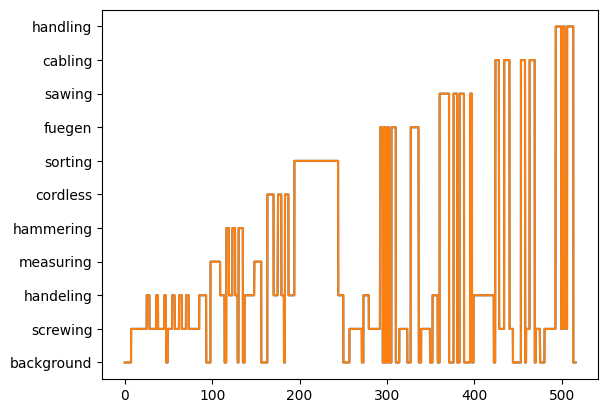

In [14]:
#quick check whether the labels & time stamps overlap

import matplotlib.pyplot as plt

plt.plot(export_L['timestamp_mills_ms'], export_L['label'])
plt.plot(export_R['timestamp_mills_ms'], export_R['label'])
plt.show()

**Plots**

In [15]:
start = 0
end = -1

#x_L / R --> timestamps, where 0 is the start of the recording. As data was cut, recording might not start at 0.
#hence first element has to be subtracted

x_L = (data_L['timestamp_mills_ms'][start:end] - data_L['timestamp_mills_ms'][0]) / 1000
ax_L = data_L['AX'][start:end]
ay_L = data_L['AY'][start:end]
az_L = data_L['AZ'][start:end]
gx_L = data_L['GX'][start:end]
gy_L = data_L['GY'][start:end]
gz_L = data_L['GZ'][start:end]

x_R = (data_R['timestamp_mills_ms'][start:end] - data_R['timestamp_mills_ms'][0]) / 1000
ax_R = data_R['AX'][start:end]
ay_R = data_R['AY'][start:end]
az_R = data_R['AZ'][start:end]
gx_R = data_R['GX'][start:end]
gy_R = data_R['GY'][start:end]
gz_R = data_R['GZ'][start:end]


labels = labels_full.loc[labels_full['from'] >= x_L.iloc[0]]
labels = labels.loc[labels['from'] <= x_L.iloc[-1]]

print(labels)

         label hand    from      to  duration
0   background    b    0.00    7.18      7.18
1     screwing    r    7.18   14.11      6.93
2     screwing    b   14.11   18.12      4.01
3     screwing    r   18.12   20.19      2.07
4     screwing    b   20.19   25.02      4.83
..         ...  ...     ...     ...       ...
92    screwing    r  503.17  506.04      2.87
93    handling    b  506.04  508.19      2.15
94    handling    l  508.19  510.13      1.94
95    handling    b  510.13  513.14      3.01
96  background    b  513.14  516.09      2.95

[97 rows x 5 columns]


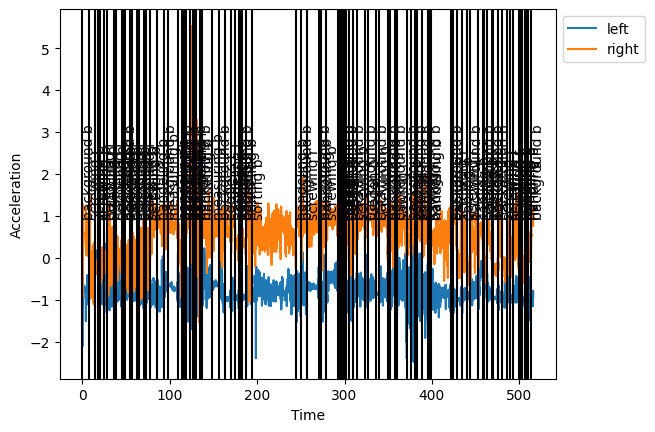

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(x_L, ax_L, label='left')
plt.plot(x_R, ax_R, label='right')

#plt.xticks([])
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Time")
plt.ylabel("Acceleration")

for row in labels.iterrows():
    plt.axvline(row[1]['from'], color='k')
    plt.text(row[1]['from'], 1, row[1]['label'] + ' ' + row[1]['hand'], rotation=90)

plt.show()